In [140]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import plotly.graph_objects as go

from scipy.signal import savgol_filter
from scipy.fft import fft, ifft
from scipy.signal import butter,filtfilt

# %matplotlib widget

In [141]:
def modifyTimestamps(df):

    df = df.dropna()
    df = df.drop(df.filter(regex='Name..').columns, axis=1)
    df = df.rename(columns={"Name": "Time"})

    return df


def LDAP_to_time(t_array):

    timestamp_array = []

    for timestamp in t_array:

        if type(timestamp) == pd._libs.tslibs.timestamps.Timestamp:
            timestamp_array.append(timestamp)

        else:
            value = datetime.datetime(1601, 1, 1) + datetime.timedelta(seconds=timestamp/10000000)
            timestamp_array.append(value)

    return np.asarray(timestamp_array)

#### **Loading Data** and **Modifying Time Column**

In [142]:
# powerFailureDf = pd.read_csv('Power Anomalies Simulations Data/AD3_data/001_PowerFailure_With_Drive.csv', sep=';')
# powerFailureDf = modifyTimestamps(df=powerFailureDf)

powerFailureDf = pd.read_csv('Power Anomalies Simulations Data/AD3_data/002_PowerFailure_With_Drive_On and Off.csv', sep=';')
powerFailureDf = modifyTimestamps(df=powerFailureDf)

# powerFailureDf = pd.read_csv('Power Anomalies Simulations Data/AD3_data/Simulations 12 Mar/01_Power Failure.csv', sep=';')
# powerFailureDf = modifyTimestamps(df=powerFailureDf)

voltageSagDf = pd.read_csv('Power Anomalies Simulations Data/AD3_data/Simulations 12 Mar/02_Voltage sag.csv', sep=';')
voltageSagDf = modifyTimestamps(df=voltageSagDf)

In [143]:
df = powerFailureDf

In [144]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#             # x = time.to_numpy(),
#             y = powerFailureDf['U_L1real'],
#             line =  dict(shape =  'spline', color = 'lightskyblue'),
#             name = 'Noisy V1',
#             ))

# fig.add_trace(go.Scatter(
#             y = powerFailureDf["I_L1real"],
#             line =  dict(shape =  'spline', color = 'lightsalmon'),
#             name = 'Noisy I1'
#             ))

# fig.show()

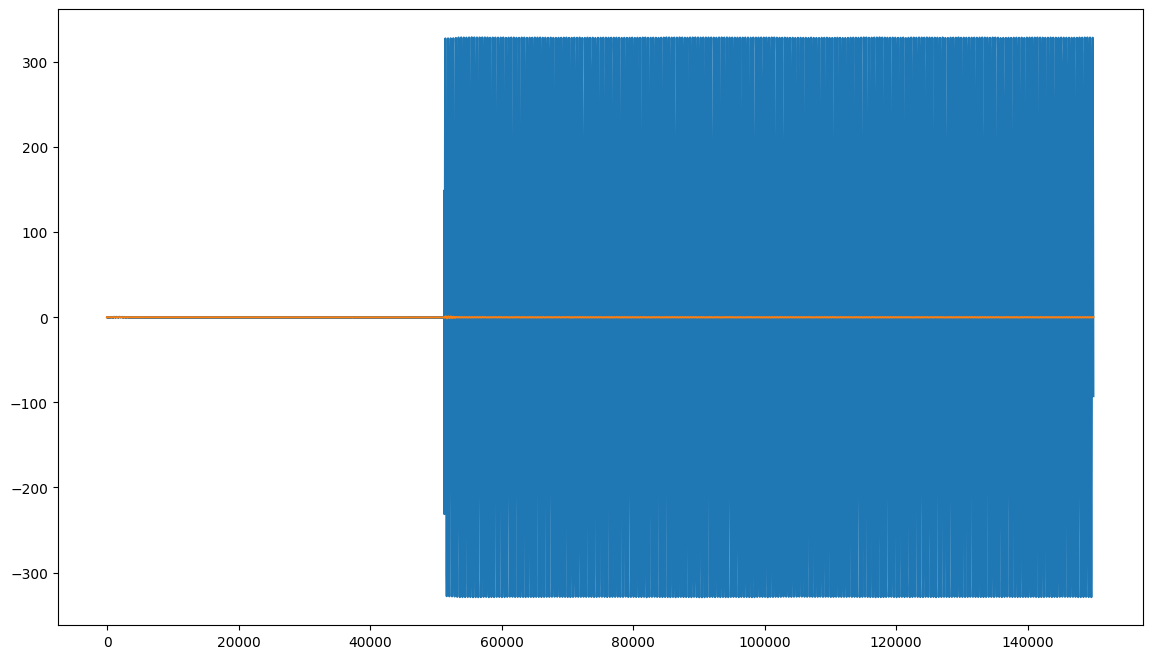

In [145]:
fig = plt.figure(figsize=(14, 8))

V1_complete = df['U_L1real'].iloc[150000:].to_numpy()
I1_complete = df['I_L1real'].iloc[150000:].to_numpy()
T_complete = df['Time'].iloc[150000:].to_numpy()

plt.plot(V1_complete)
plt.plot(I1_complete)

plt.show()

#### **Getting 10 cycles of AC signals** and **Converting to timestamps**

In [146]:
# start   =   154000
start   =   50000
end     =   start + 4000

V1  =   df['U_L1real'].iloc[start:end].to_numpy()
I1  =   df['I_L1real'].iloc[start:end].to_numpy()

T   =   df['Time'].iloc[start:end].to_numpy()
T   =   LDAP_to_time(t_array=T)

In [147]:
fig = go.Figure()

fig.add_trace(go.Scatter(
            # x = time.to_numpy(),
            y = V1,
            line =  dict(shape =  'spline', color = 'lightskyblue'),
            name = 'Noisy V1',
            ))

fig.add_trace(go.Scatter(
            y = I1,
            line =  dict(shape =  'spline', color = 'lightsalmon'),
            name = 'Noisy I1'
            ))

fig.update_layout(
    title='Noisy Signals',
    # xaxis_title='',
    yaxis_title='Signal Value',
)

fig.show()

#### **Defining Low Pass Filter** and **Filtering V and I signals**

In [148]:
def butter_lowpass_filter(signal, cutoff, fs, order):

    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq

    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, signal)
    
    return y

In [149]:
sampling_freq   =   20000.0         # sampling frequency of the signal (Hz)
cutoff_freq     =   1000             # desired cutoff frequency of the filter (Hz)
order           =   2               # sine wave can be approx represented as quadratic

V1_filt = butter_lowpass_filter(signal=V1, cutoff=cutoff_freq, fs=sampling_freq, order=order)
I1_filt = butter_lowpass_filter(signal=I1, cutoff=cutoff_freq, fs=sampling_freq, order=order)

In [150]:
fig = go.Figure()

fig.add_trace(go.Scatter(
            # x = time.to_numpy(),
            y = V1,
            line =  dict(shape =  'spline', color = 'lightskyblue'),
            name = 'Noisy U1',
            ))

fig.add_trace(go.Scatter(
            y = V1_filt,
            line =  dict(shape =  'spline', color = 'darkslategrey'),
            name = 'Filtered U1'
            ))

fig.update_layout(
    title='Voltage Curve',
    # xaxis_title='',
    yaxis_title='Voltage (V)',
)

fig.show()

In [151]:
fig = go.Figure()

fig.add_trace(go.Scatter(
            y = I1,
            line =  dict(shape =  'spline', color = 'lightsalmon'),
            name = 'Noisy I1',
            ))

fig.add_trace(go.Scatter(
            y = I1_filt,
            line =  dict(shape =  'spline', color = 'darkslategrey'),
            name = 'Filtered I1',
            ))

fig.update_layout(
    title='Current Curve',
    # xaxis_title='',
    yaxis_title='Current (A)',
)

fig.show()

In [152]:
fig = go.Figure()

fig.add_trace(go.Scatter(
            y = V1_filt,
            line =  dict(shape =  'spline', color = 'darkcyan'),
            name = 'Filtered V1',
            ))

fig.add_trace(go.Scatter(
            y = I1_filt,
            line =  dict(shape =  'spline', color = 'darksalmon'),
            name = 'Filtered I1',
            ))

fig.update_layout(
    title='Filtered Signals',
    # xaxis_title='',
    yaxis_title='Signal Value',
)

fig.show()

#### **Calculating Phase Angle**

In [153]:
# !!! rather than using limits to check zero-crossing, check where the signal goes from -ve to +ve (or vice-versa)

def phaseAngle(V_array, I_array, time_array):
    
    try:
        # zero_crossings_V_filt = list(np.asarray((-0.1 <= V_array) & (V_array <= 0.1)).nonzero())[0]
        # zero_crossings_I_filt = list(np.asarray((-0.0025 <= I_array) & (I_array <= 0.0025)).nonzero())[0]

        zero_crossings_V_filt = np.where(V_array[:-1] * V_array[1:] < 0 )[0] +1
        zero_crossings_I_filt = np.where(I_array[:-1] * I_array[1:] < 0 )[0] +1

        # Get the time stamps when V and I cross zero
        time_stamps_V = time_array[zero_crossings_V_filt]
        time_stamps_I = time_array[zero_crossings_I_filt]

        # Compute the phase angle between V and I signals
        td = pd.Timedelta(seconds=1)
        time_delta = (time_stamps_V[0] - time_stamps_I[0]) / td

        phase_angle_degrees = 360 * 50 * time_delta

        return phase_angle_degrees
    

    except:

        phase_angle_degrees = 0
        return phase_angle_degrees

In [154]:
phase_angle_degrees = phaseAngle(V_array=V1_filt, I_array=I1_filt, time_array=T)

print(f'Phase Angle: {phase_angle_degrees} degrees')

Phase Angle: -63.936 degrees


#### **Calculating Power**

In [155]:
def power(V_array, I_array, time_array):

    phase_angle = phaseAngle(V_array=V_array, I_array=I_array, time_array=time_array)
    power_array = np.multiply(V_array, I_array) * np.cos(phase_angle)
    return power_array

In [156]:
P1 = power(V_array=V1_filt, I_array=I1_filt, time_array=T)
P1

array([11.02476296, 11.44093205, 11.86348286, ...,  9.39668364,
        9.82113657, 10.22523706])

In [157]:
fig = go.Figure()

fig.add_trace(go.Scatter(
            y = P1,
            line =  dict(shape =  'spline', color = 'darkcyan'),
            name = 'P1',
            ))

fig.update_layout(
    title='Power Curve',
    # xaxis_title='',
    yaxis_title='Power (W)',
)

fig.show()

#### **Calculating FFT**, **Harmonics present in the signal** and **THD**

In [158]:
def THD(signal, fs=20000, THD_threshold = 8.):

    X = fft(signal)
    N = len(X)
    n = np.arange(N)
    T = N/fs

    freq = (n/T)[1:int(N/2)] 
    freq_amplitudes = np.abs(X)[1:int(N/2)]

    sorted_indices = np.argsort(-freq_amplitudes)

    dominant_freq = freq[sorted_indices[0]]
    other_freq = freq[sorted_indices[1:]]


    sq_sum = np.sum(np.square(freq_amplitudes))

    sq_prime = np.square(np.max(freq_amplitudes))
    sq_harmonics = sq_sum - sq_prime

    THD_signal = 100 * np.sqrt(sq_harmonics / sq_prime)

    if THD_signal > (THD_threshold): print(f'THD: {THD_signal} % Threshold Exceeded')

    return (freq, freq_amplitudes, dominant_freq, other_freq, THD_signal)

In [159]:
freq, freq_amplitudes, dominant_freq, other_freq, THD_V1_filt = THD(signal=V1_filt, fs=sampling_freq, THD_threshold=8.)

print(f'\nPrime Harmonic:                     {dominant_freq} Hz')
print(f'Next 10 Harmonics:                  {other_freq[:10]}\n')
print(f'Total Harmonic Distortion (THD):    {THD_V1_filt} %')

fig = go.Figure()

fig.add_trace(go.Scatter(x=freq, y=freq_amplitudes, mode='lines', line=dict(color='blue'), name='FFT Amplitude |X(freq)|'))
fig.update_layout(
    title='FFT Visualization',
    xaxis_title='Freq (Hz)',
    yaxis_title='FFT Amplitude |X(freq)|',
    xaxis=dict(range=[0, sampling_freq/2])
)

fig.show()


Prime Harmonic:                     50.0 Hz
Next 10 Harmonics:                  [ 350.  250.  550.  850.   45.  950.   55.  650. 1150.  750.]

Total Harmonic Distortion (THD):    1.3704654168433987 %


#### **Calculating RMS Voltage** according to **IEEE 1564-2024**

In [160]:
def rms_cycle(signal, time_array, threshold, sag_start_time=None, sag_end_time=None):

    for i in np.arange(start=0, stop=len(signal), step=200):

        start = i
        end = i + 400

        rms = np.sqrt(np.mean(np.square(signal[start:end])))


        if rms < (0.9 * threshold): 
            print(f'Sag: {time_array[i]}  |  RMS Value: {rms}')
            
            if sag_start_time == None: 
                sag_start_time = time_array[i]
                sag_end_time = None


        elif (0.9 * threshold <= rms) & (rms <= 1.1 * threshold):

            if (sag_start_time != None) & (sag_end_time == None):
                sag_end_time = time_array[i]


        # elif rms > (1.1 * threshold): print(f'Swell: {time_array[i]}  |  RMS Value: {rms}')


    return sag_start_time, sag_end_time




# V_threshold = 1.5/np.sqrt(2)
# V_threshold = 220
# rms_cycle(signal=V1_filt, time_array=T, threshold=V_threshold)

print(f'\nRMS voltage of complete signal: {np.max(V1_filt)/np.sqrt(2)} V')


RMS voltage of complete signal: 232.3995790154537 V


In [161]:
def anomalyDetection(V_array, I_array, time_array, fs=sampling_freq,
                     V_threshold=220, sag_start_time=None, sag_end_time=None,
                     THD_threshold=8.0):

    print(f'\nStart: {time_array[0]}')

    V1_filt = butter_lowpass_filter(signal=V_array, cutoff=cutoff_freq, fs=sampling_freq, order=order)
    I1_filt = butter_lowpass_filter(signal=I_array, cutoff=cutoff_freq, fs=sampling_freq, order=order)

    sag_start_time, sag_end_time = rms_cycle(signal=V1_filt, time_array=T, 
                                             threshold=V_threshold, sag_start_time=sag_start_time, sag_end_time=sag_end_time)
    
    
    freq, freq_amplitudes, dominant_freq, other_freq, THD_V1 = THD(signal=V1_filt, fs=fs, THD_threshold=THD_threshold)

    # print(f'sag start: {sag_start_time}\nsag end: {sag_end_time}')
    # print(f'THD: {THD_V1} %')
    
    return sag_start_time, sag_end_time

In [162]:
V1_complete = df['U_L1real'].iloc[:].to_numpy()
I1_complete = df['I_L1real'].iloc[:].to_numpy()
T_complete = df['Time'].iloc[:].to_numpy()


sampling_freq   =   20000.0         # sampling frequency of the signal (Hz)
cutoff_freq     =   1000             # desired cutoff frequency of the filter (Hz)
order           =   2               # sine wave can be approx represented as quadratic

V_threshold     =   220
# V_threshold = np.max(V1_complete)/np.sqrt(2)

sag_start_time  =   None
sag_end_time    =   None

THD_threshold   =   8.


for i in np.arange(start=0, stop=len(V1_complete), step=4000):

    start = i
    end = start + 4000

    V1 = V1_complete[start:end]
    I1 = I1_complete[start:end]

    T = T_complete[start:end]
    T = LDAP_to_time(t_array=T)

    if len(V1) >= 400:
        
        sag_start_time, sag_end_time = anomalyDetection(V_array=V1, I_array=I1, time_array=T,
                                                        V_threshold=V_threshold, sag_start_time=sag_start_time, sag_end_time=sag_end_time)


        if (sag_start_time != None) & (sag_end_time != None):

            print(f'\n\nsag start final: {sag_start_time}\nsag end final: {sag_end_time}')

            sag_duration = sag_end_time - sag_start_time
            print(f'Sag Duration: {sag_duration}')

            sag_start_time = None
            sag_end_time = None
            # print(f'{type(sag_start_time)}\n{type(sag_end_time)}')


Start: 2024-03-21 11:17:11.507000
Sag: 2024-03-21 11:17:11.507000  |  RMS Value: 0.15334225504855906
Sag: 2024-03-21 11:17:11.517000  |  RMS Value: 0.11429086191585261
Sag: 2024-03-21 11:17:11.527000  |  RMS Value: 0.18607573291323973
Sag: 2024-03-21 11:17:11.537001  |  RMS Value: 0.19997672267699945
Sag: 2024-03-21 11:17:11.547001  |  RMS Value: 0.24155552614157774
Sag: 2024-03-21 11:17:11.556999  |  RMS Value: 0.25386624093750165
Sag: 2024-03-21 11:17:11.566999  |  RMS Value: 0.27304152191018083
Sag: 2024-03-21 11:17:11.577000  |  RMS Value: 0.2766298492678468
Sag: 2024-03-21 11:17:11.587000  |  RMS Value: 0.27266063792844686
Sag: 2024-03-21 11:17:11.597000  |  RMS Value: 0.26607967427036333
Sag: 2024-03-21 11:17:11.607000  |  RMS Value: 0.24502543179508057
Sag: 2024-03-21 11:17:11.617001  |  RMS Value: 0.23417200068755836
Sag: 2024-03-21 11:17:11.627001  |  RMS Value: 0.21097278626320656
Sag: 2024-03-21 11:17:11.636999  |  RMS Value: 0.2036397145344513
Sag: 2024-03-21 11:17:11.6469